# eXponential Family Dynamical Systems (XFADS): Large-scale nonlinear Gaussian state-space modeling

<a target="_blank" href="https://colab.research.google.com/github/catniplab/xfads/blob/workshop/workshop/monkey_reaching/main.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br>Approximate inference targeted at variational Gaussian state-space models with dense covariance matrix approximations.  For more details, see our paper: [Dowling, Zhao, Park. 2024](https://arxiv.org/abs/2403.01371)

This is a walk-through for the minimal functioning of XFADS. We will be building a toy model on the [MC_Maze](https://neurallatents.github.io/datasets.html) dataset as a benchmark, which is a delayed center-out reaching task with barriers.<br>
With the adequate configs, you can fit XFADS on different spans of neural data.

## Installation
After cloning the repo, and installing anaconda, or miniconda, create the environment by running:<br>
`conda env create -f environment.yaml`<br>

Add the `xfads` package to the `PYTHONPATH` of the environment<br>
`pip install -e .`<br>

If you are on Google Colab, which is recommended (just make sure to zip and download the trained models), run the following cell to clone the repo and install the requirements, and you are ready to go!<br>
(Since Colab uses sessions anyway, it won't be that useful to use an environment.)

In [18]:
def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_running_in_colab():
    !git clone https://github.com/catniplab/xfads.git
    %cd xfads
    # install the dependencies
    !pip install torch pytorch-lightning scikit-learn hydra-core matplotlib einops
    # wrap the XFADS package
    !pip install -e .

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import random
import hydra

from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import torch
import pytorch_lightning as lightning

from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from mc_utils import *

from hydra import compose, initialize
from xfads import plot_utils
from xfads.smoothers.lightning_trainers import LightningMonkeyReaching
from xfads.ssm_modules.prebuilt_models import create_xfads_poisson_log_link

In [22]:
torch.cuda.empty_cache()

In [105]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="", job_name="monkey_reaching")

cfg = compose(config_name="config")

In [107]:
lightning.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)

Seed set to 1236


## Loading the data
Here we are using the [MC_Maze:](https://dandiarchive.org/dandiset/000128?search=mc_maze&pos=4) macaque primary motor and dorsal premotor cortex spiking activity during delayed reaching.

In [ ]:
! dandi download DANDI:000128/0.220113.0400 --output-dir ./data
%run download_data_from_nwb.py

In [29]:
data_path = 'data/data_{split}_{bin_sz_ms}ms.pt'
train_data = torch.load(data_path.format(split='train', bin_sz_ms=cfg.bin_sz_ms))
val_data = torch.load(data_path.format(split='valid', bin_sz_ms=cfg.bin_sz_ms))
test_data = torch.load(data_path.format(split='test', bin_sz_ms=cfg.bin_sz_ms))

y_train_obs = train_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_valid_obs = val_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_test_obs = test_data['y_obs'].type(torch.float32).to(cfg.data_device)

vel_train = train_data['velocity'].type(torch.float32).to(cfg.data_device)
vel_valid = val_data['velocity'].type(torch.float32).to(cfg.data_device)
vel_test = test_data['velocity'].type(torch.float32).to(cfg.data_device)

y_train_dataset = torch.utils.data.TensorDataset(y_train_obs, vel_train)
y_val_dataset = torch.utils.data.TensorDataset(y_valid_obs, vel_valid)
y_test_dataset = torch.utils.data.TensorDataset(y_test_obs, vel_test)

train_dataloader = torch.utils.data.DataLoader(y_train_dataset, batch_size=cfg.batch_sz, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(y_val_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)
test_dataloader = torch.utils.data.DataLoader(y_test_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)

# Data dimensions
n_train_trials, n_time_bins, n_neurons_obs = y_train_obs.shape
n_valid_trials = y_valid_obs.shape[0]
n_test_trials = y_test_obs.shape[0]
n_time_bins_enc = train_data['n_time_bins_enc']

print("# training trials: {0}".format(n_train_trials))
print("# validation trials: {0}".format(n_valid_trials))
print("# testing trials: {0}".format(n_test_trials))
print("# neurons: {0}".format(n_neurons_obs))
print("# time bins: {0}".format(n_time_bins))
print("# time bins used for forcasting: {0}".format(cfg.n_bins_bhv))
print("# predicted time bins: {0}".format(n_time_bins - cfg.n_bins_bhv))

# training trials: 1721
# validation trials: 287
# testing trials: 287
# neurons: 182
# time bins: 45
# time bins used for forcasting: 10
# predicted time bins: 35


## Structuring the state-space model
The modules of the XFADS package are organized in a modular way, allowing the users to change and plug in their own definitions of the classes that structure the elements of the model, i.e. the dynamics function, the likelihood density, the amortization network, etc.

The configuration depends on the problem - `dynamics_mod`, `initial_c_pdf`, `likelihood_pdf`, `local_encoder`, and `backward_encoder` can be configured as desired. We include some general classes in `ssm_modules/encoders`, `ssm_modules/likelihoods`, and `ssm_modules/dynamics` that should be sufficient for a wide range of problems.  Below is an example configuration.

In each iteration of the variational inference, we need to optimize the parameters of the approximate posterior, which can be quite inefficient, to enable amortized inference for the state-space model, we follow the technique of using a trainable NN, known as an **inference network** or **recognition network**, to predict these parameters from the observed data.

A possible drawback of the traditional inference frameworks is that missing observations obstruct inference, i.e. cannot naturally accommodate missing data. But in a state-space graphical model, the latent state posterior should be accessible for every time point even with missing observations. To enable the amortized inference network to process missing observations in a principled way, we decompose the natural parameter update into two additive components: i) a **local encoder**, for current observation, and ii) a **backward encoder**, for future observations.

For a detailed step-by-step development of XFADS, check the Method section of [the paper](https://arxiv.org/abs/2403.01371).

In [31]:
"""create ssm"""
ssm = create_xfads_poisson_log_link(cfg, n_neurons_obs, train_dataloader, model_type='n')

"""lightning"""
seq_vae = LightningMonkeyReaching(ssm, cfg, n_time_bins_enc, cfg.n_bins_bhv)
csv_logger = CSVLogger('logs/smoother/acausal/', name=f'sd_{cfg.seed}_r_y_{cfg.rank_local}_r_b_{cfg.rank_backward}', version='smoother_acausal')
ckpt_callback = ModelCheckpoint(save_top_k=3, monitor='r2_valid_enc', mode='max', dirpath='ckpts/smoother/acausal/', save_last=True,
                                filename='{epoch:0}_{valid_loss:0.2f}_{r2_valid_enc:0.2f}_{r2_valid_bhv:0.2f}_{valid_bps_enc:0.2f}')

seq_vae.ssm.eval()

LowRankNonlinearStateSpaceModel(
  (nl_filter): NonlinearFilter(
    (dynamics_mod): DenseGaussianDynamics(
      (mean_fn): DynamicsGRU(
        (gru_cell): GRUCell(0, 128)
        (h_to_z): Linear(in_features=128, out_features=40, bias=True)
        (z_to_h): Linear(in_features=40, out_features=128, bias=True)
      )
    )
    (initial_c_pdf): DenseGaussianInitialCondition()
  )
  (dynamics_mod): DenseGaussianDynamics(
    (mean_fn): DynamicsGRU(
      (gru_cell): GRUCell(0, 128)
      (h_to_z): Linear(in_features=128, out_features=40, bias=True)
      (z_to_h): Linear(in_features=40, out_features=128, bias=True)
    )
  )
  (local_encoder): LocalEncoderLRMvn(
    (mlp): Sequential(
      (0): Linear(in_features=182, out_features=256, bias=True)
      (1): SiLU()
      (2): Dropout(p=0.4, inplace=False)
      (3): Linear(in_features=256, out_features=640, bias=True)
    )
  )
  (initial_c_pdf): DenseGaussianInitialCondition()
  (likelihood_pdf): PoissonLikelihood(
    (readout_fn): 

## Training and saving the model

In [ ]:
trainer = lightning.Trainer(max_epochs=cfg.n_epochs,
                            gradient_clip_val=1.0,
                            default_root_dir='lightning/',
                            callbacks=[ckpt_callback],
                            logger=csv_logger,
                            )

trainer.fit(model=seq_vae, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)
torch.save(ckpt_callback.best_model_path, 'ckpts/smoother/acausal/best_model_path.pt')
trainer.test(dataloaders=test_dataloader, ckpt_path='last')

## Loading the trained model

In [35]:
"""lightning"""
model_ckpt_path = 'ckpts/smoother/acausal/epoch=692_valid_loss=1415.51_r2_valid_enc=0.89_r2_valid_bhv=0.73_valid_bps_enc=0.41.ckpt'
seq_vae = LightningMonkeyReaching.load_from_checkpoint(model_ckpt_path, ssm=ssm, cfg=cfg,
                                                       n_time_bins_enc=n_time_bins_enc, n_time_bins_bhv=cfg.n_bins_bhv,
                                                       strict=False)
"""extract trained ssm from lightning module"""
seq_vae.ssm = seq_vae.ssm.to(cfg.device)

## Evaluating model performance

In [38]:
z_s_train = []
z_s_valid = []
z_f_valid = []
z_p_valid = []
stats_valid = []

for batch in train_dataloader:
    
    loss, z, stats = seq_vae.ssm(batch[0], cfg.n_samples)
    z_s_train.append(z)

for batch in valid_dataloader:
    
    z_f, stats = seq_vae.ssm.fast_filter_1_to_T(batch[0], cfg.n_samples)
    loss, z, stats = seq_vae.ssm(batch[0], cfg.n_samples)
    
    z_p = seq_vae.ssm.predict_forward(z_f[:, :, 10], cfg.n_samples)
    z_p = torch.cat([z_f[:, :, :10], z_p], dim=2)
    
    z_f_valid.append(z_f)
    z_p_valid.append(z_p)
    z_s_valid.append(z)
    stats_valid.append(stats)

In [42]:
U, S, V = torch.svd(seq_vae.ssm.likelihood_pdf.readout_fn[-1].weight.data)
V = S.unsqueeze(-1) * V

z_s_train = torch.cat(z_s_train, dim=1)
z_s_valid = torch.cat(z_s_valid, dim=1)
z_f_valid = torch.cat(z_f_valid, dim=1)
z_p_valid = torch.cat(z_p_valid, dim=1)

z_s_train = z_s_train[..., :cfg.n_latents_read] @ V
z_s_test = z_s_valid[..., :cfg.n_latents_read] @ V
z_f_test = z_f_valid[..., :cfg.n_latents_read] @ V
z_p_test = z_p_valid[..., :cfg.n_latents_read] @ V

In [44]:
"""colors"""
blues = cm.get_cmap("winter", z_s_test.shape[0])
reds = cm.get_cmap("summer", z_s_test.shape[0])
springs = cm.get_cmap("spring", z_s_test.shape[0])

color_map_list = [blues, reds, springs]

/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_54884/2082696959.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blues = cm.get_cmap("winter", z_s_test.shape[0])
/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_54884/2082696959.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reds = cm.get_cmap("summer", z_s_test.shape[0])
/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_54884/2082696959.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  

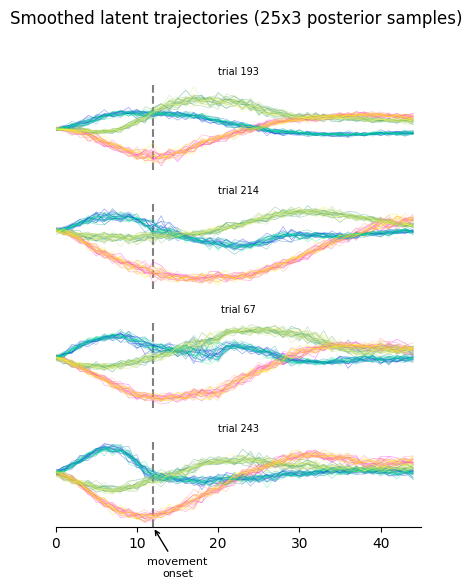

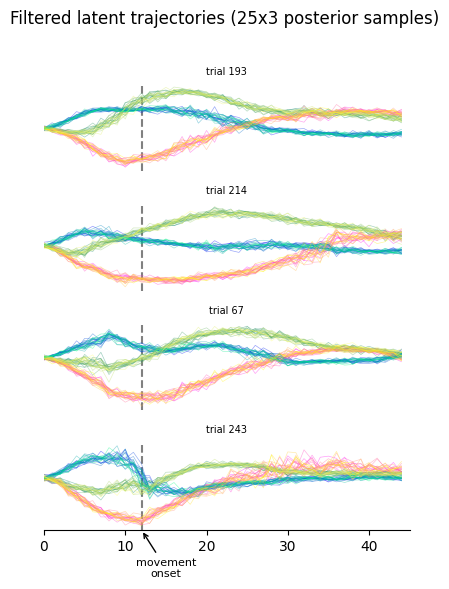

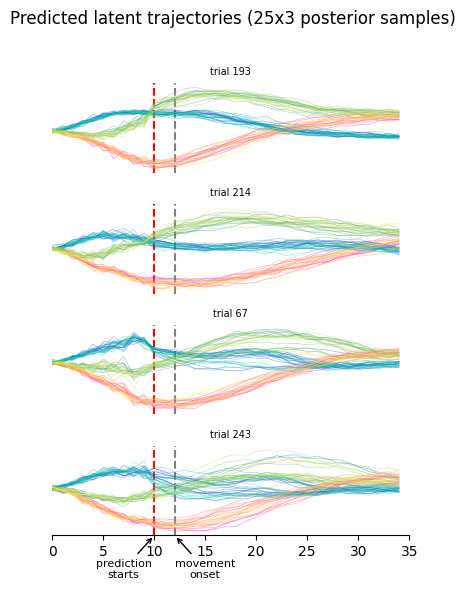

In [50]:
trial_indcs = np.random.choice(range(0, y_valid_obs.shape[0]), size=4, replace=False)

"""smoothed"""
with torch.no_grad():

    fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(4, 6))
    
    plot_z_samples(fig, axs, z_s_test, trial_indcs, cfg.move_onset, cfg.n_bins_bhv, color_map_list)
    
    fig.suptitle('Smoothed latent trajectories (25x3 posterior samples)\n')
    fig.tight_layout()
    
    y_min, _ = plt.ylim()
    
    plt.annotate('movement\nonset', xy=(cfg.move_onset, y_min), xytext=(cfg.move_onset+3, y_min+0.9*y_min),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    plt.tight_layout()
    plt.show()

"""filtered"""
with torch.no_grad():

    fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(4, 6))
    
    plot_z_samples(fig, axs, z_f_test, trial_indcs, cfg.move_onset, cfg.n_bins_bhv, color_map_list)
    
    fig.suptitle('Filtered latent trajectories (25x3 posterior samples)\n')
    fig.tight_layout()
    
    y_min, _ = plt.ylim()
    
    plt.annotate('movement\nonset', xy=(cfg.move_onset, y_min), xytext=(cfg.move_onset+3, y_min+0.9*y_min),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    plt.tight_layout()
    plt.show()
    
"""predicted"""
with torch.no_grad():

    fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(4, 6))
    [axs[i].axvline(10, linestyle='--', color='red') for i in range(len(trial_indcs))]
    
    plot_z_samples(fig, axs, z_p_test, trial_indcs, cfg.move_onset, cfg.n_bins_bhv, color_map_list)

    fig.suptitle('Predicted latent trajectories (25x3 posterior samples)\n')
    fig.tight_layout()
    
    y_min, _ = plt.ylim()
                 
    plt.annotate('movement\nonset', xy=(cfg.move_onset, y_min), xytext=(cfg.move_onset+3, y_min+0.9*y_min),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
        
    plt.annotate('prediction\nstarts', xy=(cfg.n_bins_bhv, y_min), xytext=(cfg.n_bins_bhv-3, y_min+0.9*y_min),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    plt.tight_layout()
    plt.show()

## Filtering, Smoothing, and Prediction
There is a trick we worked on to conceptualize the approximate smoothing problem as an approximate filtering problem for pseudo-observations that encode a representation of current and future data.

We draw inspiration from a quintessential facet of conjugate Bayesian inference: natural parameters of the posterior are a sum-separable combination of the natural parameters of the prior in addition to a data-dependent term. The latter can now be thought of as a data-dependent update to the prior for a conjugate pseudo-observation.

Importantly, pseudo-observations defined this way encode the current *and* future observations of the raw data – an essential component for transforming the statistical smoothing problem into an alternative filtering problem.

The next figure illustrates the smoothing and predictive performance of XFADS trained on the mc_maze data. To the left of the red line are samples from the posterior during the data window, and to the right of the red line are samples unrolled from $p_{\theta}(z_t | z_{t-1})$.

So, we end up with three regimes:
**Filtering**, **Smoothing**, and **Prediction**.

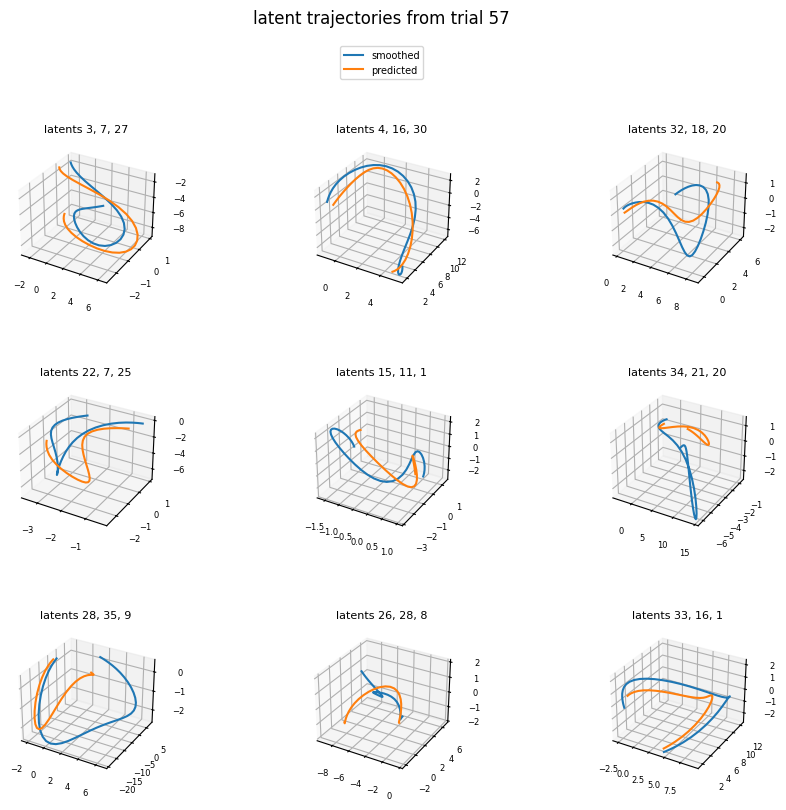

In [56]:
with torch.no_grad():
    
    trial_idx = np.random.randint(0, n_valid_trials)
    
    n_trajectories_to_plot = 9
    n_latents_to_plot = 3

    fig, axes = plt.subplots(int(np.sqrt(n_trajectories_to_plot)), int(np.sqrt(n_trajectories_to_plot)), figsize=(10, 8), subplot_kw={'projection': '3d'})
    fig.tight_layout()
    fig.suptitle(f'latent trajectories from trial {trial_idx+1}\n\n\n\n')
    
    for i, ax in enumerate(axes.flat):
        
        latent1, latent2, latent3 = np.random.choice(range(0, cfg.n_latents_read), size=n_latents_to_plot, replace=False)
        
        # Select three latent dimensions for 3D plotting
        x = torch.tensor(gaussian_filter1d(torch.mean(z_s_test[:, trial_idx, ..., latent1], dim=0), sigma=4, axis=0))
        y = torch.tensor(gaussian_filter1d(torch.mean(z_s_test[:, trial_idx, ..., latent2], dim=0), sigma=4, axis=0))
        z = torch.tensor(gaussian_filter1d(torch.mean(z_s_test[:, trial_idx, ..., latent3], dim=0), sigma=4, axis=0))

        ax.plot(x, y, z, label='smoothed' if i == 0 else '')
        
        x_p = torch.tensor(gaussian_filter1d(torch.mean(z_p_test[:, trial_idx, ..., latent1], dim=0), sigma=4, axis=0))
        y_p = torch.tensor(gaussian_filter1d(torch.mean(z_p_test[:, trial_idx, ..., latent2], dim=0), sigma=4, axis=0))
        z_p = torch.tensor(gaussian_filter1d(torch.mean(z_p_test[:, trial_idx, ..., latent3], dim=0), sigma=4, axis=0))
        
        ax.tick_params(axis='x', labelsize=6)
        ax.tick_params(axis='y', labelsize=6)
        ax.tick_params(axis='z', labelsize=6)
        
        ax.plot(x_p, y_p, z_p, label='predicted' if i == 0 else '')
        
        ax.set_title(f'latents {latent1+1}, {latent2+1}, {latent3+1}', fontsize=8)
    
    plt.tight_layout()

    fig.subplots_adjust(hspace=0.6)
    
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=1, fontsize=7)
    
    plt.show()

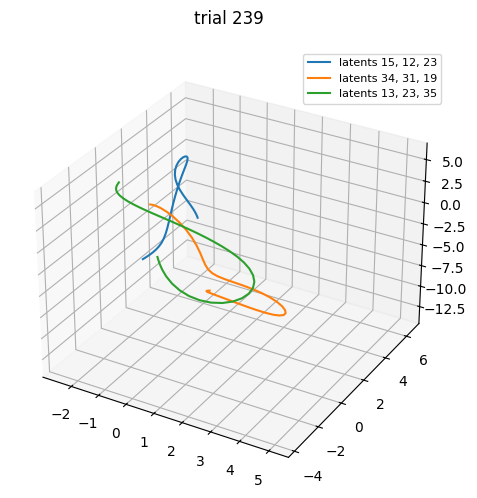

In [62]:
with torch.no_grad():

    fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': '3d'})
    fig.tight_layout()
    
    n_latents_to_plot = 3
    n_trajectories_to_plot = 3
    
    trial_idx = np.random.randint(0, z_s_test.shape[1])
    
    for i in range(n_trajectories_to_plot):
        
        # Any random 3 latents
        latent1, latent2, latent3 = np.random.choice(range(0, cfg.n_latents_read), size=n_latents_to_plot, replace=False)

        # Select three latent dimensions for 3D plotting
        x = torch.tensor(
            gaussian_filter1d(
                torch.mean(
                    z_s_test[:, trial_idx, ..., latent1], dim=0), sigma=4, axis=0))
        
        y = torch.tensor(
            gaussian_filter1d(
                torch.mean(
                    z_s_test[:, trial_idx, ..., latent2], dim=0), sigma=4, axis=0))
        
        z = torch.tensor(
            gaussian_filter1d(
                torch.mean(
                    z_s_test[:, trial_idx, ..., latent3], dim=0), sigma=4, axis=0))

        ax.plot(x, y, z, label=f'latents {latent1+1}, {latent2+1}, {latent3+1}')
        
    ax.legend(fontsize=8)
    
    fig.suptitle(f'trial {trial_idx+1}')
    plt.tight_layout()
    
    plt.show()

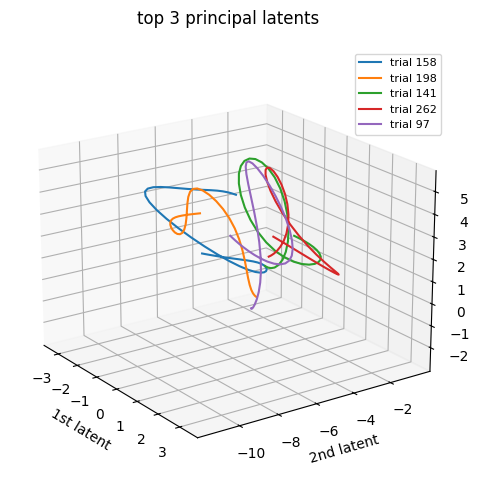

In [64]:
with torch.no_grad():

    fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': '3d'})
    fig.tight_layout()
    
    n_latents_to_plot = 3
    n_trajectories_to_plot = 5
    
    trials_inds = np.random.choice(range(0, y_valid_obs.shape[0]), size=n_trajectories_to_plot, replace=False)
    
    # top 3 latents (not indices)
    latent1, latent2, latent3 = [0, 1, 2]
    
    for i in range(n_trajectories_to_plot):

        # Select three latent dimensions for 3D plotting
        x = torch.tensor(
            gaussian_filter1d(
                torch.mean(
                    z_s_test[:, trials_inds[i], ..., latent1], dim=0), sigma=4, axis=0))
        
        y = torch.tensor(
            gaussian_filter1d(
                torch.mean(
                    z_s_test[:, trials_inds[i], ..., latent2], dim=0), sigma=4, axis=0))
        
        z = torch.tensor(
            gaussian_filter1d(
                torch.mean(
                    z_s_test[:, trials_inds[i], ..., latent3], dim=0), sigma=4, axis=0))

        ax.plot(x, y, z, label=f'trial {trials_inds[i]+1}')
        
    ax.legend(fontsize=8)
    ax.view_init(elev=20., azim=-35)
    ax.set_xlabel('1st latent')
    ax.set_ylabel('2nd latent')
    ax.set_zlabel('3rd latent')
    
    fig.suptitle(f'top 3 principal latents')
    plt.tight_layout()
    
    plt.show()

In [ ]:
# reading the logs

logs_path = 'logs/smoother/acausal/sd_1236_r_y_15_r_b_5/smoother_acausal/metrics.csv'
metrics = pd.read_csv(logs_path).to_dict()

In [ ]:
metrics.keys()

In [ ]:
# Plot the training and validation loss

plt.figure(figsize=(10, 5))

plt.plot(
    metrics['train_loss'].keys(),
    metrics['train_loss'].values(),
    marker='o', markersize=2, linestyle='-', color='g', alpha=0.6, linewidth=1, label='train')

plt.plot(
    metrics['valid_loss'].keys(),
    metrics['valid_loss'].values(),
    marker='o', markersize=2, linestyle='-', color='y', alpha=0.6, linewidth=1, label='valid')

# plt.title('Training and Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (ELBO)')

plt.legend()

plt.show()

In [ ]:
# Plot the training and validation loss

plt.figure(figsize=(10, 5))

plt.plot(
    list(metrics['r2_train_enc'].keys())[1:],
    list(metrics['r2_train_enc'].values())[1:],
    marker='o', markersize=2, linestyle='-', color='g', alpha=0.6, linewidth=1, label='train')

plt.plot(
    list(metrics['r2_valid_enc'].keys())[1:],
    list(metrics['r2_valid_enc'].values())[1:],
    marker='o', markersize=2, linestyle='-', color='y', alpha=0.6, linewidth=1, label='valid')

#plt.title('R2')

plt.xlabel('Epochs')
plt.ylabel('r2')

plt.legend()

plt.show()

Another way to evaluate model performance is the **Bits per Spike (BpS)**. Which is a quantification of how neurons encode information.

In [ ]:
# Plot the training and validation loss

plt.figure(figsize=(10, 5))

plt.plot(
    metrics['train_bps_enc'].keys(),
    metrics['train_bps_enc'].values(),
    marker='o', markersize=2, linestyle='-', color='g', alpha=0.6, linewidth=1, label='train')

plt.plot(
    metrics['valid_bps_enc'].keys(),
    metrics['valid_bps_enc'].values(),
    marker='o', markersize=2, linestyle='-', color='y', alpha=0.6, linewidth=1, label='valid')

plt.xlabel('Epochs')
plt.ylabel('bits per spike')

plt.legend()

plt.show()

The previous plots were all about the evolution of the model performance throughout training (loss x epochs). Aonther way to evaluate how the model captures the tuning properties of neurons relative to the stimulus over time is to look at the **peri-stimulus time histogram (PSTH)**.

We will generate condition averaged (in our example, conditions are the reaching directions) PSTHs from the model and compare them to the condition averaged PSTHs from the data.

In [ ]:
trial_indcs = np.random.choice(range(0, y_valid_obs.shape[0]), size=4, replace=False)

with torch.no_grad():

    fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(4, 8))
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    plot_z_2d(fig, axs, z_f_test, trial_indcs, cfg.move_onset, cfg.n_bins_bhv, default_colors[0], regime='filtering')
    plot_z_2d(fig, axs, z_p_test, trial_indcs, cfg.move_onset, cfg.n_bins_bhv, default_colors[1], regime='prediction')
    
    #fig.suptitle('First 3 latents over time, for all neurons, from 4 test trials \n (smoothing regime) \n')
    fig.suptitle('filtered vs predicted\n\n\n\n')
    fig.tight_layout()
    
    y_min, _ = plt.ylim()
                 
    plt.annotate('movement\nonset', xy=(cfg.move_onset, y_min), xytext=(cfg.move_onset+3, y_min+0.9*y_min),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
        
    plt.annotate('prediction\nstarts', xy=(cfg.n_bins_bhv, y_min), xytext=(cfg.n_bins_bhv-3, y_min+0.9*y_min),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    fig.legend(loc='upper center', bbox_to_anchor=(0.47, 0.94), shadow=True, ncol=1, fontsize=6)
    
    plt.show()

# Generating corresponding observations
We can use the likelifood function (observation model) to generate new data (log rates) from the latents. And sampele from the rates possion to get the spike counts.

Data dimentionality:\
**generated** : sampels x trials x time bins x neurons\
sampels = samples of the latents each of which used to generate the data\
**real**: trials x time bins x neurons

In [66]:
# smoothed and predicted log rates
r_s = seq_vae.ssm.to(cfg.data_device).likelihood_pdf.readout_fn(z_s_test)
r_p = seq_vae.ssm.to(cfg.data_device).likelihood_pdf.readout_fn(z_p_test)
# sampeling from the rates possion to get the spike counts
y_s = torch.poisson(cfg.bin_sz * torch.exp(r_s))
y_p = torch.poisson(cfg.bin_sz * torch.exp(r_p))

y_hat = torch.cat([y_s[:, :, :cfg.n_bins_bhv], y_p], dim=2)
z_hat = torch.cat([z_s_test[:, :, :cfg.n_bins_bhv, :], z_p_test], dim=2)
i = 41

/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_54884/2978951269.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


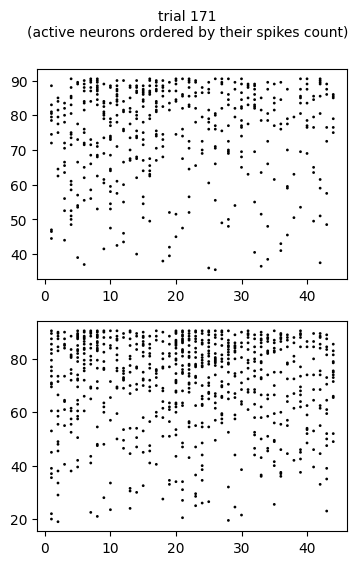

In [82]:
with torch.no_grad():
    
    trial_idx = np.random.randint(0, y_test_obs.shape[0])

    fig, axs = plt.subplots(2, 1, figsize=(4, 6))
    plot_spikes(y_test_obs[trial_idx], axs[0])
    plot_spikes(y_hat[0, trial_idx], axs[1]) # from the first posterior sample (dim0 = 0)

    fig.suptitle(f'trial {trial_idx}\n(active neurons ordered by their spikes count)', fontsize=10)
    
    fig.show()

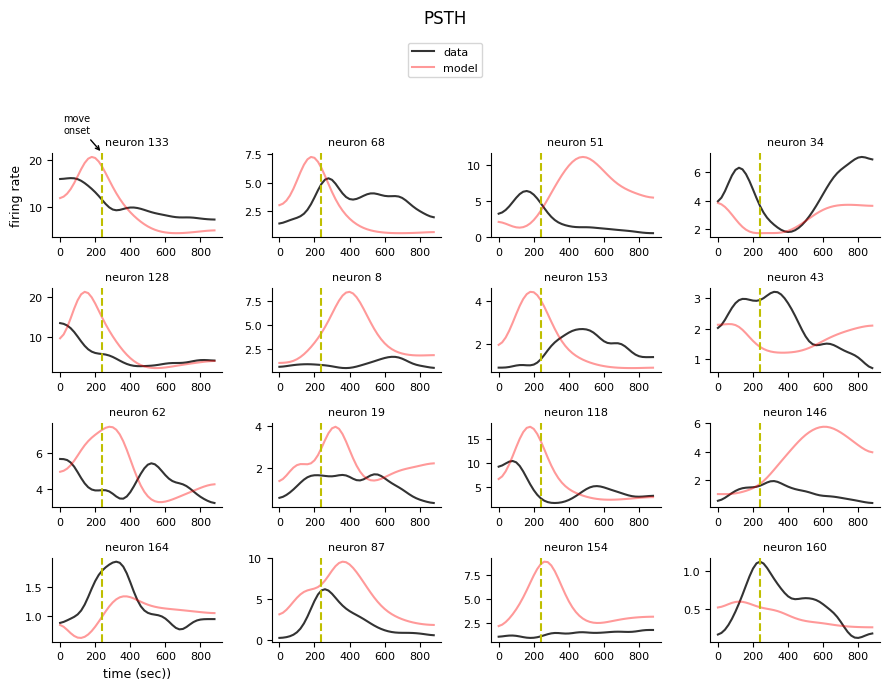

In [536]:
with torch.no_grad():

    n_eurons_to_plot = 16
    neuron_incs = np.random.choice(range(0, y_valid_obs.shape[2]), size=n_eurons_to_plot, replace=False)

    fig, axes = plt.subplots(int(np.sqrt(n_eurons_to_plot)), int(np.sqrt(n_eurons_to_plot)), figsize=(9, 7))
    fig.suptitle(f'PSTH\n\n\n')

    for ax, neuron in zip(axes.flat, neuron_incs):

        fr_data = torch.tensor(
            gaussian_filter1d(
                torch.mean(y_valid_obs[:, :, neuron], axis=0) / cfg.bin_sz,
                sigma=2.5, axis=0))

        fr_model= torch.tensor(
            gaussian_filter1d(
                torch.mean(torch.exp(torch.mean(r_s, axis=0)), axis=0)[:, neuron],
                sigma=2.5, axis=0))

        ax.plot(np.arange(n_time_bins) * cfg.bin_sz_ms, fr_data, color= 'black', alpha=0.8, label='data' if neuron == neuron_incs[-1] else '')
        ax.plot(np.arange(n_time_bins) * cfg.bin_sz_ms, fr_model, color= 'red', alpha=0.4, label='model' if neuron == neuron_incs[-1] else '')

        ax.set_title(f'neuron {neuron+1}', fontsize=8)
        ax.set_xlabel('time (sec))' if neuron == neuron_incs[-int(np.sqrt(n_eurons_to_plot))] else '', fontsize=9)
        ax.set_ylabel('firing rate' if neuron == neuron_incs[0] else '', fontsize=9)
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

        ax.axvline(x=cfg.move_onset*cfg.bin_sz_ms, color='y', linestyle='--')
        
        if neuron == neuron_incs[0]:
            y_upper_limit = ax.get_ylim()[1]

            ax.annotate('move\nonset',
                        xy=(cfg.move_onset*cfg.bin_sz_ms, y_upper_limit),
                        xytext=((cfg.move_onset*cfg.bin_sz_ms)*0.4, y_upper_limit*1.2),
                        arrowprops=dict(facecolor='black', arrowstyle='->'),
                        fontsize=7, ha='center')
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=1, fontsize=8)
    fig.tight_layout()

plt.show()

<Figure size 1600x600 with 0 Axes>

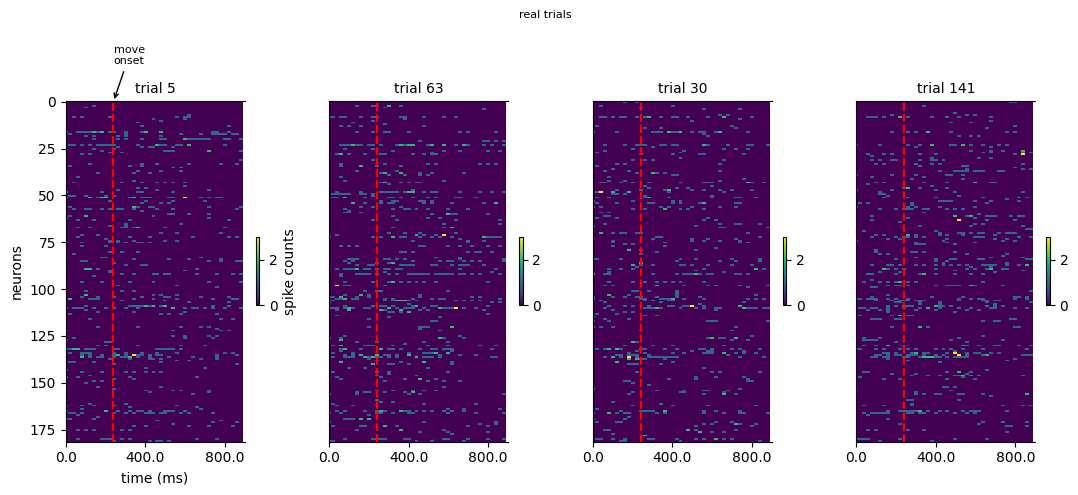

<Figure size 1600x600 with 0 Axes>

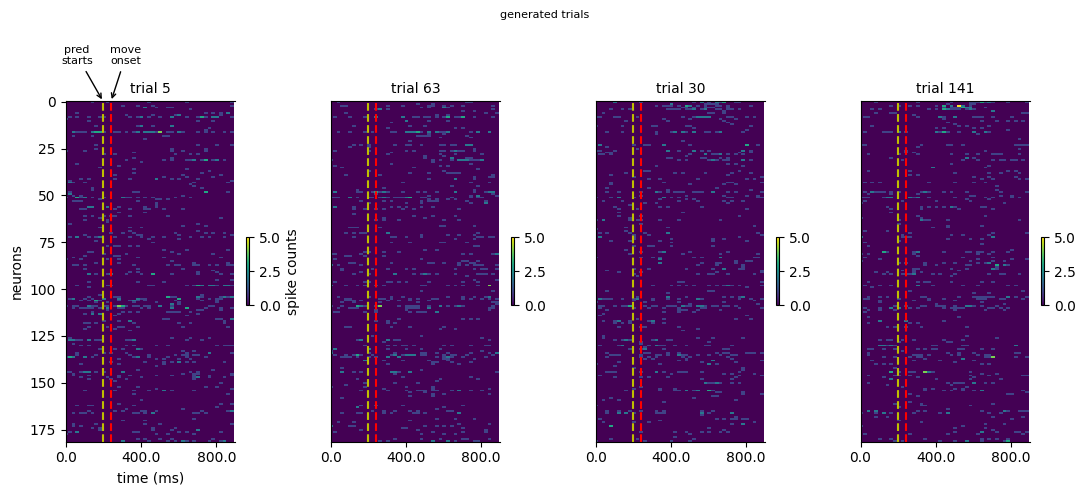

In [115]:
trials_inds = np.random.choice(range(0, y_valid_obs.shape[0]), size=4, replace=False)

plot_rastor(y_valid_obs, z_s_test, trials_inds, y_valid_obs.shape[2], cfg)
plot_rastor(y_hat[0], z_s_test, trials_inds, y_hat.shape[3], cfg, regime='prediction')

## Ordering the neurons in terms of their loading to the 1st principal latent dimension

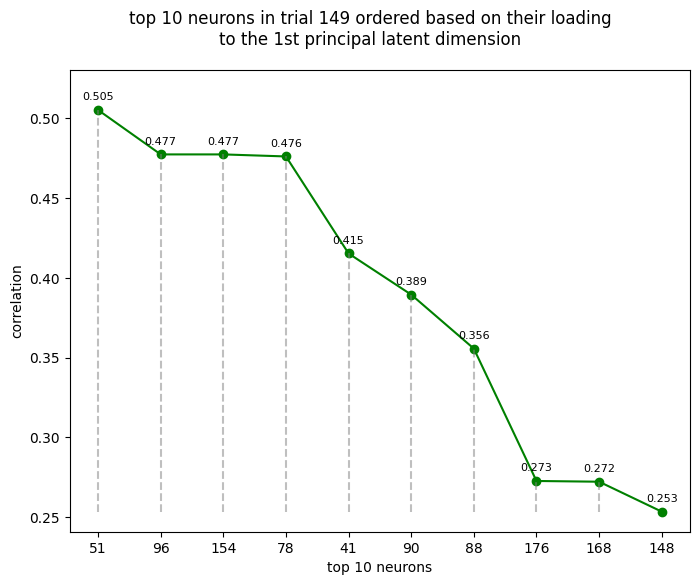

In [135]:
trial_idx = np.random.randint(0, y_valid_obs.shape[0])
ordered_correlations, ordered_neurons = order_neurons(y_valid_obs, z_s_test, trial=trial_idx, latent=0)

top_n = 10

time_bins = [str(i) for i in ordered_neurons[:top_n].astype('int32')]

y = np.abs(ordered_correlations.T[1][:top_n])

plt.ion()

fig, axes = plt.subplots(figsize=(8, 6))

axes.plot(time_bins, y, marker='o', linestyle='-', color='g')

for i in range(len(time_bins)):
    plt.text(time_bins[i], y[i]+0.005, f'{y[i]:.3f}', ha='center', va='bottom', fontsize=8)
    plt.vlines(i, ymin=y.min(), ymax=y[i], linestyles='dashed', colors='gray', alpha=0.5)

fig.suptitle(f'top 10 neurons in trial {trial_idx+1} ordered based on their loading\nto the 1st principal latent dimension\n\n\n\n')
plt.ylim(top=y.max()+0.05*y.max())

plt.xlabel('top 10 neurons')
plt.ylabel('correlation')

plt.show()

<Figure size 1600x600 with 0 Axes>

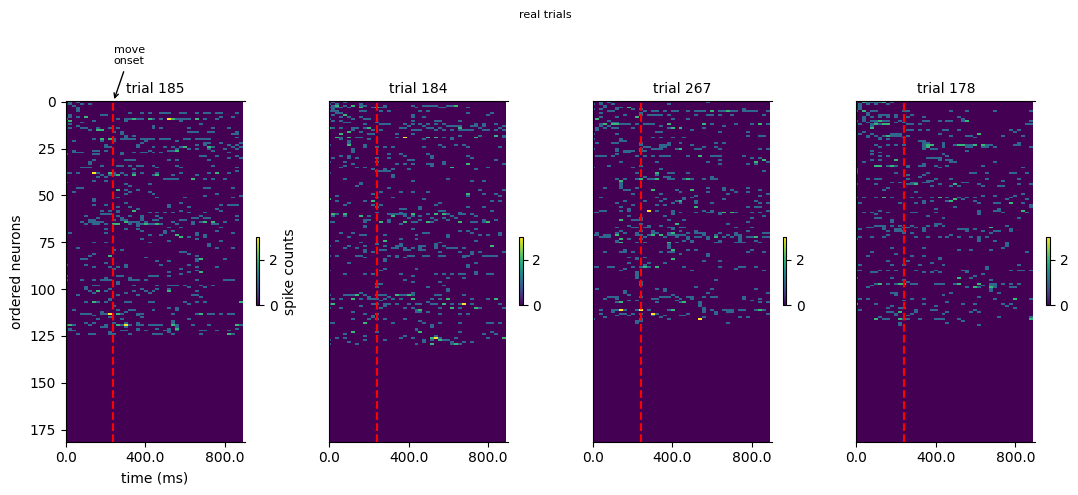

<Figure size 1600x600 with 0 Axes>

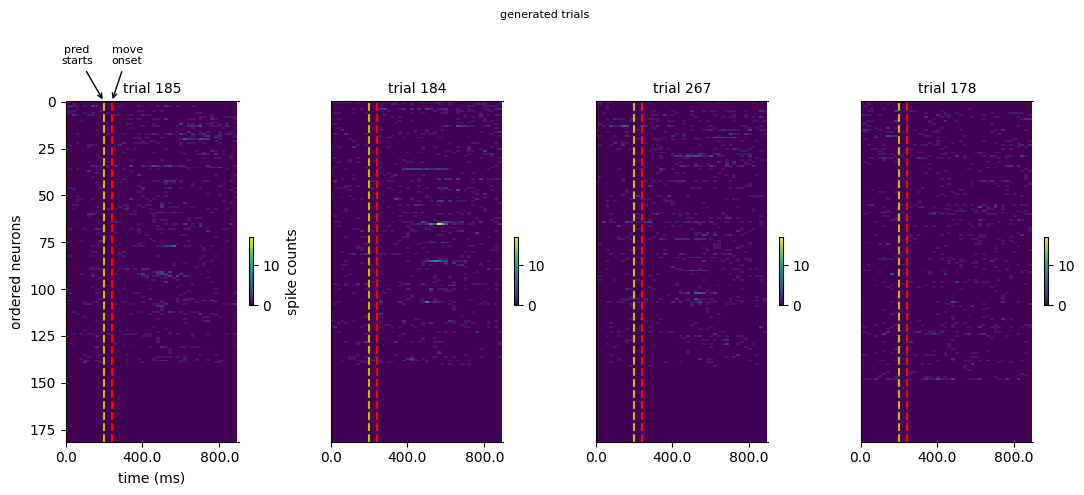

In [268]:
trials_inds = np.random.choice(range(0, y_valid_obs.shape[0]), size=4, replace=False)

plot_rastor(y_valid_obs, z_s_test, trials_inds, y_valid_obs.shape[2], cfg, order=True)
plot_rastor(y_hat[0], z_s_test, trials_inds, y_hat.shape[3], cfg, regime='prediction', order=True)

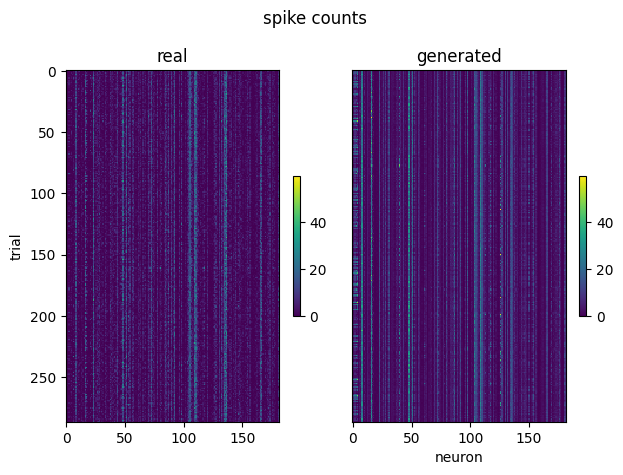

In [312]:
data_spike_count = torch.sum(y_valid_obs, axis=1)
model_spike_count = torch.sum(torch.mean(y_hat, axis=0), axis=1)

fig, axs = plt.subplots(ncols=2)
fig.suptitle('spike counts')

with torch.no_grad():
    
    axs[0].set_title('real')
    dsc = axs[0].imshow(data_spike_count, interpolation='none', aspect='auto')
    axs[1].set_title('generated')
    msc = axs[1].imshow(model_spike_count, interpolation='none', aspect='auto')

    vmin, _ = min(torch.min(data_spike_count.flatten(), dim=0), torch.min(model_spike_count.flatten(), dim=0))
    vmax, _ = max(torch.max(data_spike_count.flatten(), dim=0), torch.max(model_spike_count.flatten(), dim=0))

    fig.colorbar(dsc, ax=axs[0], shrink=0.4).mappable.set_clim(vmin=vmin, vmax=vmax)
    fig.colorbar(msc, ax=axs[1], shrink=0.4).mappable.set_clim(vmin=vmin, vmax=vmax)
                
axs[1].set_xlabel('neuron')
axs[0].set_ylabel('trial')

axs[1].set_yticks([])

plt.tight_layout()

plt.show()

In [330]:
torch.mean(torch.exp(r_s)[0, :, :, :], axis=0).shape

torch.Size([45, 182])

In [332]:
torch.exp(r_s)[0, :, :, :].shape

torch.Size([287, 45, 182])

In [350]:
torch.mean(torch.exp(torch.mean(r_s, axis=0)), axis=0)[:, neuron].shape

torch.Size([45])

In [336]:
torch.mean(r_s, axis=0).shape

torch.Size([287, 45, 182])